## Inference

In [1]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from Autoencoder import Autoencoder
from Autoencoder_big import ImprovedAutoencoder
import yaml
import os
import cv2
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Instantiate the model and set to eval mode
model = ImprovedAutoencoder()

# Load model.pth if exists
try:
	model.load_state_dict(torch.load("models/ImprovedAutoencoder.pth"))
except FileNotFoundError:
	print("No model.pth found")
model.to(device)
model.eval()

# Define a transform to preprocess the image
transform = transforms.Compose([
		transforms.Resize((256,256)),
		transforms.ToTensor(),
		transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
	])

# Load data path
with open("../config.yml", "r") as file:
	config = yaml.safe_load(file)
	data_path = config["dataset_path"]

Using cuda device


In [2]:
# Load and preprocess the image
# image = Image.open(os.path.join(data_path, "CrossValidation/Annotated/B22-25_0/02816.png")) # Negative
image = Image.open(os.path.join(data_path, "CrossValidation/Annotated/B22-37_0/00045_Aug1.png")).convert("RGB") # Positive
input_image = transform(image).unsqueeze(0) # Add batch dimension
print(input_image.shape)

torch.Size([1, 3, 256, 256])


In [3]:
# Perform a forward pass to get the reconstructed image
with torch.no_grad():
    reconstructed_image = model(input_image.to(device))

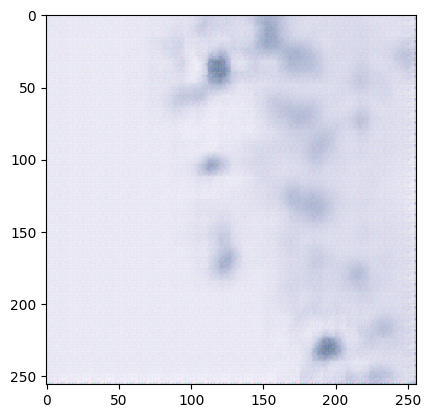

In [4]:
# plot reconstructed_image
plot_image = reconstructed_image.squeeze(0).permute(1,2,0).cpu().numpy()
plot_image = plot_image * 0.5 + 0.5
plt.imshow(plot_image)

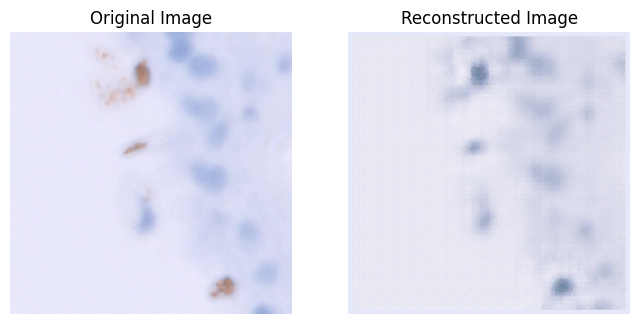

In [5]:
def postprocess(tensor, p=0):
	if tensor.dim() == 4:
		tensor = tensor.squeeze(0)
	tensor = tensor.cpu()
	tensor = tensor * 0.5 + 0.5
	tensor = tensor * 255
	tensor = tensor.clamp(0, 255)
	tensor = tensor.type(torch.uint8)
	tensor = tensor.permute(1, 2, 0).numpy()
	if p > 0:
		# center crop
		tensor = tensor[p:256-p, p:256-p, :]
		# padd again with blue color
		tensor = cv2.copyMakeBorder(tensor, p, p, p, p, cv2.BORDER_CONSTANT, value=[228, 232, 248])
	return tensor

# Convert tensors to images for visualization
input_image_np = postprocess(input_image)
reconstructed_image_np = postprocess(reconstructed_image, p=4)

# Display the original and reconstructed images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(input_image_np)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_np)
plt.axis("off")

plt.show()

# Patch classification

In [6]:
def check_red_fraction(orig, reco):
	# Convert the images from RGB to HSV
	input_image_hsv = cv2.cvtColor(orig, cv2.COLOR_RGB2HSV)
	reconstructed_image_hsv = cv2.cvtColor(reco, cv2.COLOR_RGB2HSV)

	# Define the hue range for red pixels as suggested
	# For -20 to 0 in HSV, which corresponds to hues 160-180 in OpenCV's scale
	input_lower_hsv1 = np.array([340, 0, 0])
	input_upper_hsv1 = np.array([360, 255, 255])

	# For 0 to 20 in HSV
	input_lower_hsv2 = np.array([0, 0, 0])
	input_upper_hsv2 = np.array([20, 255, 255])

	# Apply masks to the original image
	mask_ori1 = cv2.inRange(input_image_hsv, input_lower_hsv1, input_upper_hsv1)
	mask_ori2 = cv2.inRange(input_image_hsv, input_lower_hsv2, input_upper_hsv2)
	mask_ori = cv2.bitwise_or(mask_ori1, mask_ori2)
	count_red_ori = np.count_nonzero(mask_ori)

	# Apply masks to the reconstructed image
	mask_rec1 = cv2.inRange(reconstructed_image_hsv, input_lower_hsv1, input_upper_hsv1)
	mask_rec2 = cv2.inRange(reconstructed_image_hsv, input_lower_hsv2, input_upper_hsv2)
	mask_rec = cv2.bitwise_or(mask_rec1, mask_rec2)
	count_red_rec = np.count_nonzero(mask_rec)

	# Calculate the fraction of red pixels
	F_red = count_red_ori / (count_red_rec+1)

	return F_red

check_red_fraction(input_image_np, reconstructed_image_np)

101.66666666666667

In [7]:
from utils import HelicoDatasetClassification
from torch.utils.data import DataLoader

dataset = HelicoDatasetClassification()
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [8]:
next(iter(dataloader))[0].shape, next(iter(dataloader))[1]

(torch.Size([16, 3, 256, 256]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]))

In [9]:
from utils import HelicoDatasetClassification
from torch.utils.data import DataLoader
from tqdm import tqdm

dataset = HelicoDatasetClassification(patient_id=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

red_fracs = []
labels = []
patient_ids = []
for batch in tqdm(dataloader):
	b_orig_images = batch[0].to(device)
	b_labels = batch[1].to(device)
	patient_ids.extend(batch[2])
	with torch.no_grad():
		reco_images = model(b_orig_images)
	
	for i in range(len(b_orig_images)):
		red_fracs.append(check_red_fraction(
			postprocess(b_orig_images[i]),
			postprocess(reco_images[i])
		))
	labels.extend(b_labels.cpu().numpy())
labels = np.array(labels)

100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


In [10]:
print(red_fracs[:15])

[0.0, 1.2105263157894737, 1.5, 4.666666666666667, 0.0, 1.0, 0.0, 0.0, 0.38461538461538464, 0.0, 0.0, 1.9859154929577465, 1.9857142857142858, 2.517857142857143, 1.7466666666666666]


In [11]:
print(labels[:15])

[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]


AUC: 0.881
Optimal red fraction threshold: 10.03825136612022


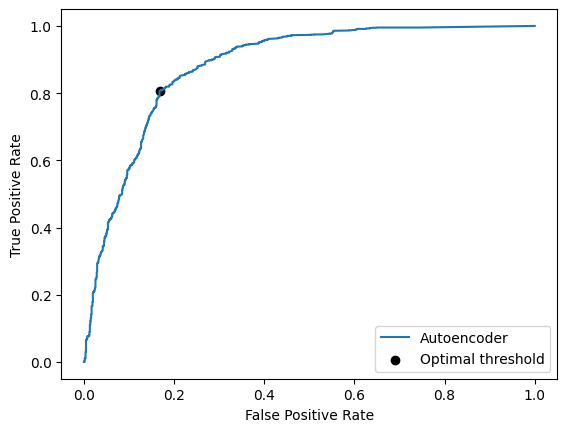

In [12]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# sort red_fracs and labels by red_fracs
red_fracs = np.array(red_fracs)
labels = np.array(labels)
inds = red_fracs.argsort()
sorted_red_fracs = red_fracs[inds]
sorted_labels = labels[inds]

# calculate roc curve
fpr, tpr, thresholds = roc_curve(sorted_labels, sorted_red_fracs)
# calculate AUC
auc = roc_auc_score(sorted_labels, sorted_red_fracs)
print('AUC: %.3f' % auc)

# find the closest point to (0,1)
optimal_idx = np.argmax(tpr - fpr)
optimal_red_frac = thresholds[optimal_idx]
print(f"Optimal red fraction threshold: {optimal_red_frac}")

# plot the roc curve for the model
plt.plot(fpr, tpr, label='Autoencoder')
# plot the optimal threshold
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='black', label='Optimal threshold')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Accuracy: 0.817
Precision: 0.870
Recall: 0.806
F1: 0.837


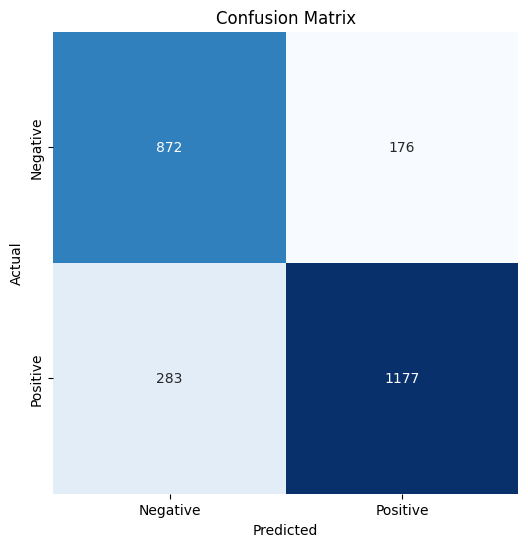

In [13]:
import seaborn as sns

# confusion matrix
y_pred = (red_fracs > optimal_red_frac).astype(int)
cm = confusion_matrix(labels, y_pred)

accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1 = 2 * (precision * recall) / (precision + recall)
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1: {f1:.3f}")

# plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Patient Diagnosis

In [15]:
from utils import HelicoDatasetPatientDiagnosis
import os
import pandas as pd

dataset = HelicoDatasetPatientDiagnosis()
dataloader = DataLoader(dataset, batch_size=248, shuffle=False)

if os.path.exists("temp/holdout_results_improved.csv"):
	holdout_results = pd.read_csv("temp/holdout_results.csv")
	red_fracs = holdout_results["red_frac"].values
	patient_ids = holdout_results["patient_id"].values
	gt_patient_diagnosis = holdout_results["diagnosis"].values
	pred_patch_class = holdout_results["pred_patch_class"].values
else:
	red_fracs = []
	patient_ids = []
	gt_patient_diagnosis = []

	for batch in tqdm(dataloader):
		b_orig_images = batch[0].to(device)
		patient_ids.extend(batch[1])
		gt_patient_diagnosis.extend(batch[2])
		with torch.no_grad():
			reco_images = model(b_orig_images)
		
		for i in range(len(b_orig_images)):
			red_fracs.append(check_red_fraction(
				postprocess(b_orig_images[i]),
				postprocess(reco_images[i])
			))

	red_fracs = np.array(red_fracs)
	patient_ids = np.array(patient_ids)
	gt_patient_diagnosis = np.array(gt_patient_diagnosis)
	pred_patch_class = (np.array(red_fracs) > optimal_red_frac).astype(int)

100%|██████████| 302/302 [13:21<00:00,  2.65s/it]


In [16]:
# save in a csv file
df = pd.DataFrame({
	"patient_id": patient_ids,
	"diagnosis": gt_patient_diagnosis,
	"pred_patch_class": pred_patch_class,
	"red_frac": red_fracs
})
df.to_csv("temp/holdout_results_improved.csv", index=False)

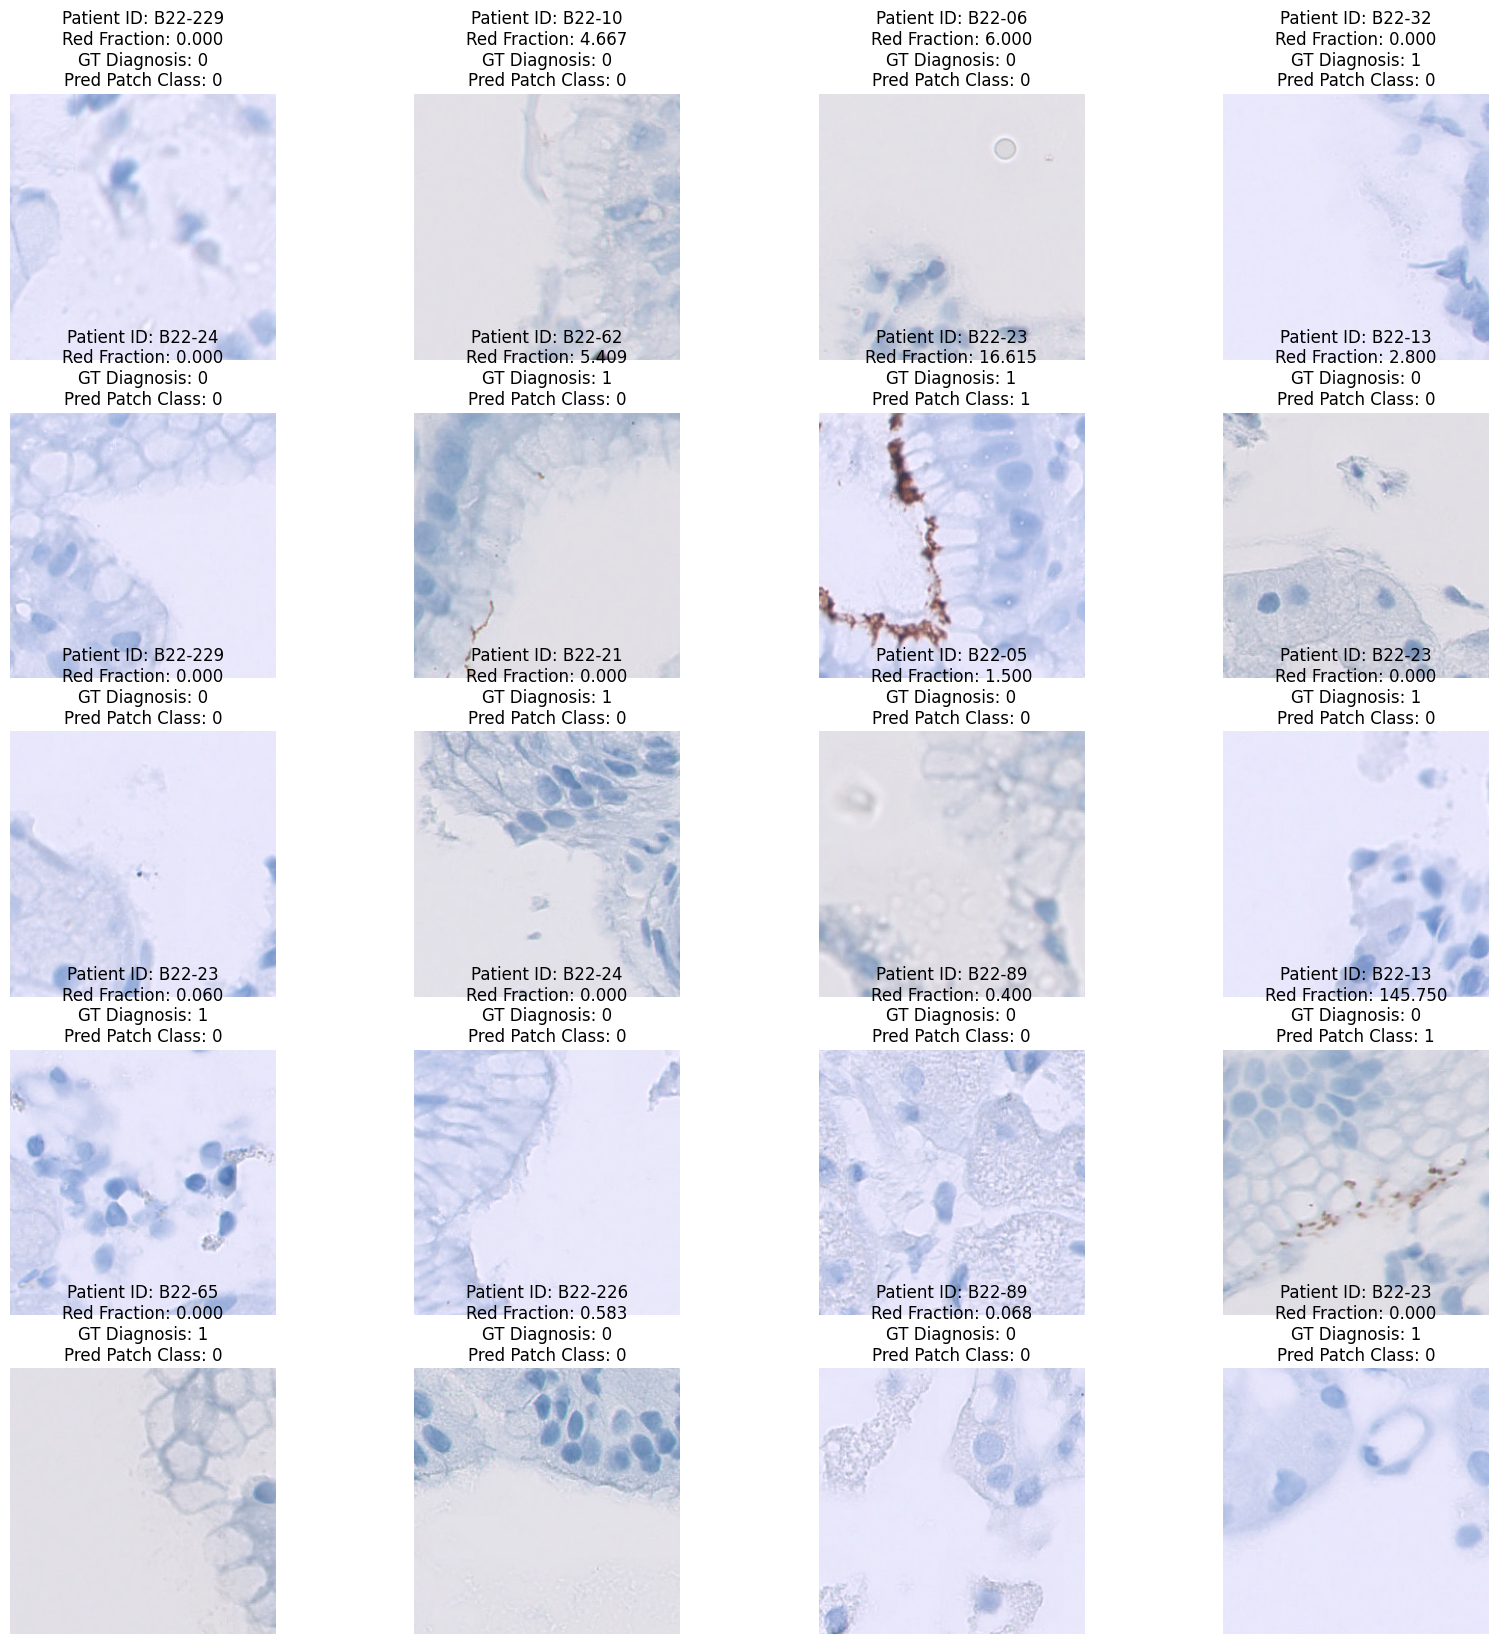

In [17]:
# visualize 20 random images with their red fraction and diagnosis
n_images = 20
rand_inds = np.random.choice(len(patient_ids), n_images, replace=False)
rand_patient_ids = patient_ids[rand_inds]
rand_red_fracs = red_fracs[rand_inds]
rand_gt_patient_diagnosis = gt_patient_diagnosis[rand_inds]
rand_pred_patch_class = pred_patch_class[rand_inds]

plt.figure(figsize=(20, 20))
for i in range(n_images):
	plt.subplot(5, 4, i+1)
	plt.title(f"Patient ID: {rand_patient_ids[i]}\nRed Fraction: {rand_red_fracs[i]:.3f}\nGT Diagnosis: {rand_gt_patient_diagnosis[i]}\nPred Patch Class: {rand_pred_patch_class[i]}")
	plt.imshow(postprocess(dataset[rand_inds[i]][0]))
	plt.axis("off")
plt.show()

In [18]:
pred_patch_class
patient_ids
count_by_patient = {}
positives_by_patient = {}
negatives_by_patient = {}
for i, patient_id in enumerate(patient_ids):
	if patient_id not in count_by_patient:
		count_by_patient[patient_id] = 0
		positives_by_patient[patient_id] = 0
		negatives_by_patient[patient_id] = 0
	count_by_patient[patient_id] += 1
	if pred_patch_class[i] == 1:
		positives_by_patient[patient_id] += 1
	else:
		negatives_by_patient[patient_id] += 1

percentage_by_patient = {}
for patient_id in count_by_patient:
	percentage_by_patient[patient_id] = positives_by_patient[patient_id] / count_by_patient[patient_id]

In [19]:
import pandas as pd

# Create a dataframe with the results
results = pd.DataFrame({
	"Patient ID": patient_ids,
	"Red Fraction": red_fracs,
	"Pred Patch Class": pred_patch_class,
	"GT patient diagnosis": gt_patient_diagnosis,
})
results.head()

,Patient ID,Red Fraction,Pred Patch Class,GT patient diagnosis
0,B22-03,0.018519,0,0
1,B22-03,0.019231,0,0
2,B22-03,0.000000,0,0
3,B22-03,0.000000,0,0
4,B22-03,0.000000,0,0


In [20]:
# count of patches, positive patches and negative patches per patient
new_results = results.groupby("Patient ID").agg({
	"Red Fraction": "count",
	"Pred Patch Class": "sum",
	"GT patient diagnosis": "first"
})
new_results["Pred Patch Class"] = new_results["Pred Patch Class"].astype(int)
new_results = new_results.rename(columns={"Red Fraction": "Total Patches", "Pred Patch Class": "Positive Patches"})
new_results["Negative Patches"] = new_results["Total Patches"] - new_results["Positive Patches"]
new_results["Percentage of Positive Patches"] = new_results["Positive Patches"] / new_results["Total Patches"] * 100
new_results.head(20)

,Total Patches,Positive Patches,GT patient diagnosis,Negative Patches,Percentage of Positive Patches
Patient ID,,,,,
B22-03,486,1,0,485,0.205761
B22-04,287,26,0,261,9.059233
B22-05,810,173,0,637,21.358025
B22-06,891,339,0,552,38.047138
B22-07,154,0,0,154,0.000000
B22-08,321,25,0,296,7.788162
B22-09,360,92,0,268,25.555556
B22-10,2634,996,0,1638,37.813212
B22-11,1217,477,0,740,39.194741


In [21]:
# percentage of positive patches per patient
pos_patches_per_patient = results.groupby("Patient ID")["Pred Patch Class"].mean().reset_index()
pos_patches_per_patient["Pred Patch Class"] = pos_patches_per_patient["Pred Patch Class"] * 100
pos_patches_per_patient.rename(columns={"Pred Patch Class": "Percentage of Positive Patches"}, inplace=True)

# add the patient diagnosis column
patient_diagnosis = results.groupby("Patient ID")["GT patient diagnosis"].first().reset_index()
pos_patches_per_patient = pos_patches_per_patient.merge(patient_diagnosis, on="Patient ID")

AUC: 0.771
Optimal threshold: 2.86425902864259


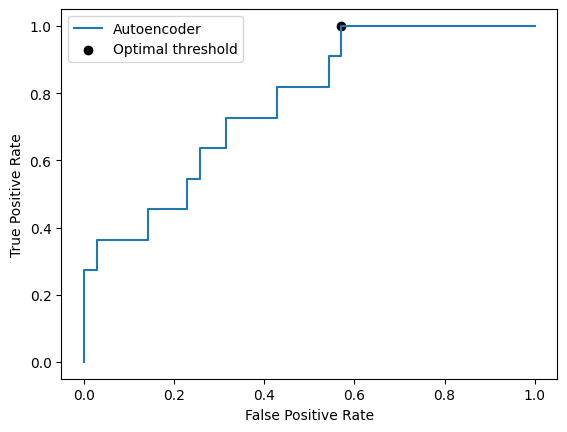

In [22]:
# sort by percentage of positive patches
pos_patches_per_patient = pos_patches_per_patient.sort_values("Percentage of Positive Patches", ascending=False)
sorted_gt = pos_patches_per_patient["GT patient diagnosis"]
sorted_preds = pos_patches_per_patient["Percentage of Positive Patches"]

# calculate roc curve
fpr, tpr, thresholds = roc_curve(sorted_gt, sorted_preds)
# calculate AUC
auc = roc_auc_score(sorted_gt, sorted_preds)
print('AUC: %.3f' % auc)

# find the closest point to (0,1)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold}")

# plot the roc curve for the model
plt.plot(fpr, tpr, label='Autoencoder')
# plot the optimal threshold
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='black', label='Optimal threshold')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [23]:
final = pos_patches_per_patient.copy()
final ["Pred Patient Diagnosis"] = (final["Percentage of Positive Patches"] > optimal_threshold).astype(int)
final.head(20)

,Patient ID,Percentage of Positive Patches,GT patient diagnosis,Pred Patient Diagnosis
39,B22-65,72.580645,1,1
38,B22-62,54.631083,1,1
43,B22-79,40.601504,1,1
8,B22-11,39.194741,0,1
40,B22-72,38.990599,1,1
3,B22-06,38.047138,0,1
7,B22-10,37.813212,0,1
9,B22-12,32.308585,0,1
6,B22-09,25.555556,0,1
35,B22-31,22.240392,1,1


Accuracy: 0.543
Precision: 0.333
Recall: 0.909
F1: 0.488


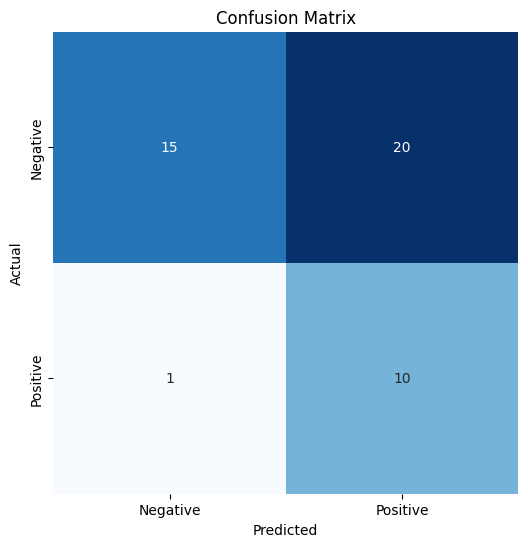

In [24]:
# confusion matrix
cm = confusion_matrix(final["GT patient diagnosis"], final["Pred Patient Diagnosis"])
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1 = 2 * (precision * recall) / (precision + recall)
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1: {f1:.3f}")

# plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()